In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
tickers = ['AAPL', 'WMT', 'JPM', 'PG', 'META', 'V']
benchmark = '^GSPC'

price = yf.download(tickers, start='2021-01-01', end='2025-03-12', progress=False)['Close'][tickers]
volume = yf.download(tickers, start='2021-01-01', end='2025-03-12', progress=False)['Volume'][tickers]

benchmark_data = yf.download(benchmark, start='2021-01-01', end='2025-03-12', progress=False)['Close']

YF.download() has changed argument auto_adjust default to True


In [4]:
def opt_sharpe(closes, rf):
    rt = closes.pct_change().dropna()
    mean_rt = rt.mean() * 252
    sigma = rt.cov() * 252

    sharpe = lambda w, rf, mean_rt, sigma: -(mean_rt.dot(w) - rf) / np.sqrt(w.dot(sigma).dot(w))

    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]

    bounds = [(0, 1) for _ in range(len(closes.columns))]
    x0 = np.ones(len(closes.columns)) / len(closes.columns)

    resultado = minimize(sharpe, x0, method='SLSQP', args=(rf, mean_rt, sigma), constraints=constraints, bounds=bounds)
    return resultado.x, resultado.fun

In [18]:
def plot(prices, w, sharpe):
    plt.figure(figsize=(6, 4))
    bars = plt.bar(prices.columns, w, width=0.3, color='cadetblue', zorder=3, edgecolor='black', linewidth=0.8)

    # Agregar etiquetas encima de cada barra
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'%{yval*100:.2f}', 
                ha='center', va='bottom', fontsize=12)

    plt.title(f'Sharpe: {-sharpe:.4f}', fontsize=16, fontweight='bold')
    plt.ylim(0, 1)
    plt.xlabel('Stocks', fontsize=14, fontweight='bold')
    plt.ylabel('Weights', fontsize=14, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.6, zorder=1)
    plt.show()

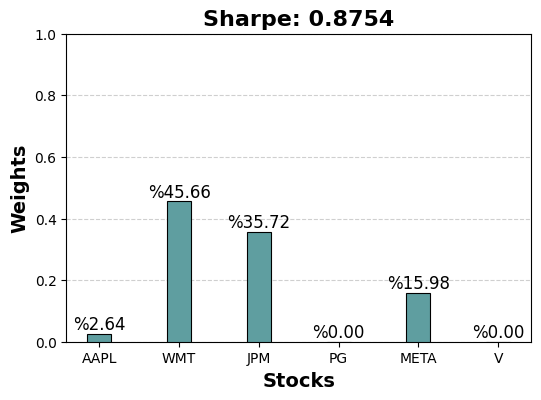

In [19]:
rf = 0.05

weights, sharpe = opt_sharpe(price, rf)
plot(price, weights, sharpe)

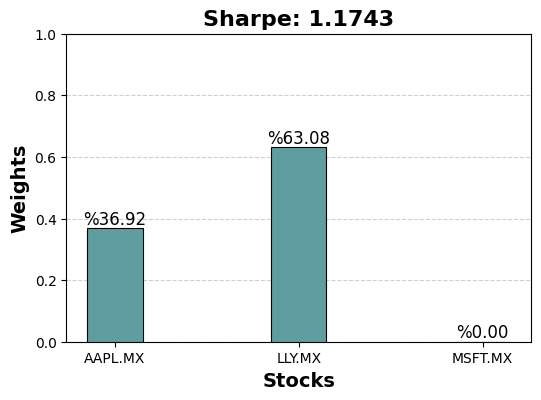

In [20]:
prueba = pd.read_csv('data_prueba.csv')
prueba['Date'] = pd.to_datetime(prueba['Date / Ticker'], dayfirst=True)
del prueba['Date / Ticker']
prueba = prueba.set_index('Date')

w, sharpe = opt_sharpe(prueba, 0.095)
plot(prueba, w, sharpe)